In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Pandas display options
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set random seed 
RSEED = 100

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

import seaborn as sns
palette = sns.color_palette('Paired', 10)

In [2]:
import tensorflow as tf

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras import layers
from tensorflow.python.keras import models

print(tf.__version__)

2.1.0


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [4]:
#Load data first time
#data = pd.read_csv('input.csv',
#                   parse_dates = ['lpep_pickup_datetime', 'lpep_dropoff_datetime'])
#data.to_pickle('full_data.pkl')
data = pd.read_pickle('full_data.pkl')
data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type
0,2,2017-01-01 00:01:15,2017-01-01 00:11:05,N,1,42,166,1,1.710,9.000,0.000,0.500,0.000,0.000,nan,0.300,9.800,2,1.000
1,2,2017-01-01 00:03:34,2017-01-01 00:09:00,N,1,75,74,1,1.440,6.500,0.500,0.500,0.000,0.000,nan,0.300,7.800,2,1.000
2,2,2017-01-01 00:04:02,2017-01-01 00:12:55,N,1,82,70,5,3.450,12.000,0.500,0.500,2.660,0.000,nan,0.300,15.960,1,1.000
3,2,2017-01-01 00:01:40,2017-01-01 00:14:23,N,1,255,232,1,2.110,10.500,0.500,0.500,0.000,0.000,nan,0.300,11.800,2,1.000
4,2,2017-01-01 00:00:51,2017-01-01 00:18:55,N,1,166,239,1,2.760,11.500,0.500,0.500,0.000,0.000,nan,0.300,12.800,2,1.000


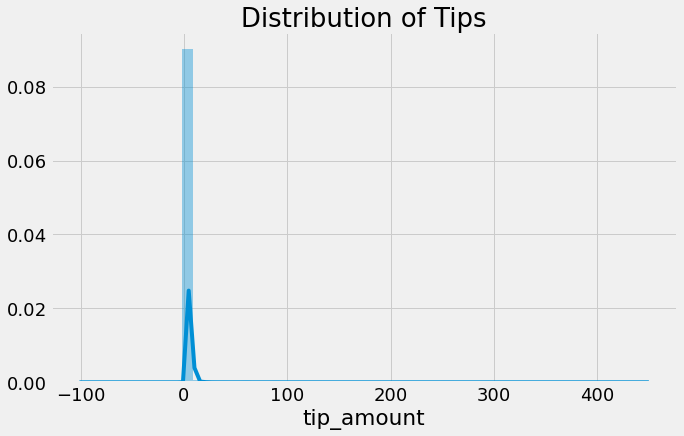

In [5]:
plt.figure(figsize = (10, 6))
sns.distplot(data['tip_amount']);
plt.title('Distribution of Tips');

In [6]:
print(f"There are {len(data[data['tip_amount'] < 0])} negative tips.")
print(f"There are {len(data[data['tip_amount'] == 0])} $0 tips.")
print(f"There are {len(data[data['tip_amount'] > 20])} tips greater than $20.")

There are 208 negative tips.
There are 6869776 $0 tips.
There are 5927 tips greater than $20.


In [7]:
data.tip_amount.quantile(0.99)

8.2

In [8]:
#For this data, use 1.5 IQR rule to detect outliers
def outlier_treatment(datacolumn, noNegativeVal):
 sorted(datacolumn)
 Q1,Q3 = np.percentile(datacolumn , [25,75])
 IQR = Q3 - Q1
 lower_range = Q1 - (1.5 * IQR)
 upper_range = Q3 + (1.5 * IQR)
 if noNegativeVal & (lower_range < 0) :
        lower_range = 0;
 return lower_range,upper_range

In [9]:
#Test to see if the function is working
lowerbound,upperbound = outlier_treatment(data.tip_amount, 1)
lowerbound, upperbound

(0, 4.875)

In [10]:
#Since it is impossible to have negative tips, distances and fare, use 0 instead
#Outlier Treatment for tip_amount
tip_lowerbound,tip_upperbound = outlier_treatment(data.tip_amount, True)
#Outlier Treatment for trip_distance
distance_lowerbound,distance_upperbound = outlier_treatment(data.trip_distance, True)
#Outlier Treatment for fare_amount
fare_lowerbound,fare_upperbound = outlier_treatment(data.trip_distance, True)
#Remove Outliers using 1.5 IQR rule
dataNoOutlier = data[data['tip_amount'].between(left = tip_lowerbound, right = tip_upperbound) & 
                     data['trip_distance'].between(left = 0.001, right = distance_upperbound) &
                    data['fare_amount'].between(left = fare_lowerbound, right = fare_upperbound)] 

#Verify if there is any inconsistent tip_amount differ from the description:
#From the data document: Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.
#Only record data where user used credit card
dataNoOutlier = dataNoOutlier[dataNoOutlier['payment_type'] == 1]

#There are only 2 type of Vendor, removing any Vendor ID that's not 1 or 2
#The following step is not needed for this data, since all Vender ID are either 1 or 2
#dataNoOutlier = dataNoOutlier[dataNoOutlier['VendorID'] == 1 or dataNoOutlier['VendorID'] == 2]
dataNoOutlier['duration'] = (dataNoOutlier['lpep_dropoff_datetime'] - dataNoOutlier['lpep_pickup_datetime']).abs()
dataNoOutlier['duration'] = dataNoOutlier['duration'] / np.timedelta64(1, 's')

#Outlier Treatment for duration
duration_lowerbound,duration_upperbound = outlier_treatment(dataNoOutlier.duration, False)
dataNoOutlier = dataNoOutlier[dataNoOutlier['duration'].between(left = duration_lowerbound, right = duration_upperbound)] 

#Speed = distance / time
dataNoOutlier['speed'] = dataNoOutlier['trip_distance'] / dataNoOutlier['duration'] * 3600
#Note that no outlier operation, since distance and duration are trimmed already
dataNoOutlier.describe()

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,duration,speed
count,1484264.000,1484264.000,1484264.000,1484264.000,1484264.000,1484264.000,1484264.000,1484264.000,1484264.000,1484264.000,1484264.000,0.000,1484264.000,1484264.000,1484264.000,1484264.000,1484264.000,1484264.000
mean,1.806,1.001,109.665,117.760,1.364,0.842,5.325,0.388,0.500,1.154,0.010,nan,0.300,7.730,1.000,1.000,283.993,11.224
std,0.395,0.064,78.085,77.955,1.051,0.276,0.892,0.379,0.012,0.666,0.839,nan,0.007,1.573,0.000,0.020,90.390,5.413
min,1.000,1.000,3.000,3.000,0.000,0.010,0.000,0.000,0.000,0.000,0.000,nan,0.000,0.000,1.000,1.000,16.000,0.067
25%,2.000,1.000,42.000,42.000,1.000,0.640,4.500,0.000,0.500,1.000,0.000,nan,0.300,6.800,1.000,1.000,218.000,8.848
50%,2.000,1.000,80.000,97.000,1.000,0.830,5.500,0.500,0.500,1.260,0.000,nan,0.300,7.800,1.000,1.000,287.000,10.760
75%,2.000,1.000,166.000,181.000,1.000,1.030,6.000,0.500,0.500,1.550,0.000,nan,0.300,8.760,1.000,1.000,352.000,13.014
max,2.000,5.000,265.000,265.000,9.000,6.600,6.580,1.000,0.500,4.840,99.000,nan,0.300,103.300,1.000,2.000,555.000,1097.143


In [11]:
dataNoOutlier.isna().sum()

VendorID                       0
lpep_pickup_datetime           0
lpep_dropoff_datetime          0
store_and_fwd_flag             0
RatecodeID                     0
PULocationID                   0
DOLocationID                   0
passenger_count                0
trip_distance                  0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
ehail_fee                1484264
improvement_surcharge          0
total_amount                   0
payment_type                   0
trip_type                      0
duration                       0
speed                          0
dtype: int64

In [12]:
dataNoOutlier.drop(columns="ehail_fee")

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,duration,speed
32,2,2017-01-01 00:01:35,2017-01-01 00:06:00,N,1,41,75,1,0.590,5.000,0.500,0.500,0.000,0.000,0.300,6.300,1,1.000,265.000,8.015
33,2,2017-01-01 00:03:58,2017-01-01 00:08:20,N,1,181,25,1,0.800,5.000,0.500,0.500,1.260,0.000,0.300,7.560,1,1.000,262.000,10.992
64,2,2017-01-01 00:34:56,2017-01-01 00:38:37,N,1,41,41,1,0.520,4.500,0.500,0.500,1.450,0.000,0.300,7.250,1,1.000,221.000,8.471
74,2,2017-01-01 00:41:12,2017-01-01 00:43:35,N,1,25,33,1,0.540,4.000,0.500,0.500,1.060,0.000,0.300,6.360,1,1.000,143.000,13.594
75,2,2017-01-01 00:51:36,2017-01-01 00:55:56,N,1,25,52,1,0.980,5.000,0.500,0.500,1.580,0.000,0.300,7.880,1,1.000,260.000,13.569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11740658,2,2017-12-31 23:30:08,2017-12-31 23:36:47,N,1,255,112,1,1.060,6.500,0.500,0.500,1.560,0.000,0.300,9.360,1,1.000,399.000,9.564
11740659,2,2017-12-31 23:08:02,2017-12-31 23:13:22,N,1,97,25,1,0.600,5.500,0.500,0.500,1.360,0.000,0.300,8.160,1,1.000,320.000,6.750
11740661,2,2017-12-31 23:29:09,2017-12-31 23:32:13,N,1,49,97,1,0.770,4.500,0.500,0.500,0.500,0.000,0.300,6.300,1,1.000,184.000,15.065
11740664,2,2017-12-31 23:05:29,2017-12-31 23:11:48,N,1,166,42,1,1.370,6.500,0.500,0.500,1.200,0.000,0.300,9.000,1,1.000,379.000,13.013


Text(0.5, 1.0, 'Tip Bin Graph')

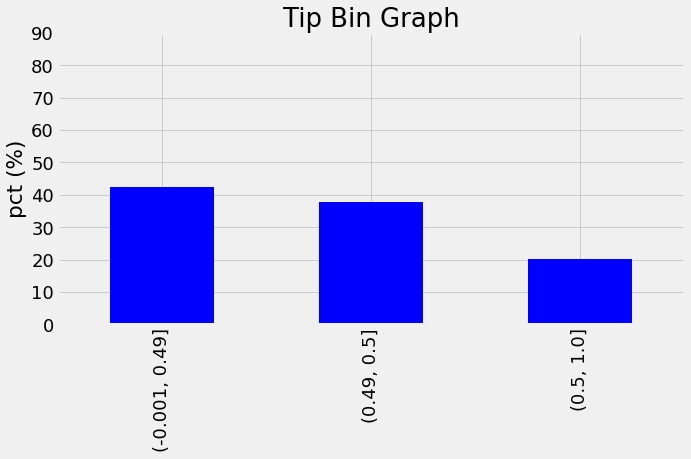

In [13]:
# Create Bar Graph for Extra Amount
bins = [0, 0.49, 0.50, 1.0]
dataNoOutlier['tip-bin'] = pd.cut(dataNoOutlier['extra'], bins, include_lowest = True)

# Bar plot of value counts
dataNoOutlier['tip-bin'].value_counts(sort=False, normalize=True).mul(100).plot.bar(figsize=(10, 5), color = 'b', yticks = range(0,100,10));
plt.ylabel("pct (%)")
plt.title('Tip Bin Graph')

In [14]:
#For Extra, Rush hour = $0.5 OverNight = $1, other is 0,Clean up any suspicious values
dataNoOutlier = dataNoOutlier[(dataNoOutlier['extra'] == 0.5) | (dataNoOutlier['extra'] == 1.0) | (dataNoOutlier['extra'] == 0.0)]
extra = dataNoOutlier.pop('extra')
dataNoOutlier['rush_hour'] = (extra == 0.5) * 1.0
dataNoOutlier['over_night'] = (extra == 1.0) * 1.0
dataNoOutlier['other'] = (extra == 0.0) * 1.0
dataNoOutlier.tail()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,improvement_surcharge,total_amount,payment_type,trip_type,duration,speed,tip-bin,rush_hour,over_night,other
11740658,2,2017-12-31 23:30:08,2017-12-31 23:36:47,N,1,255,112,1,1.060,6.500,...,0.300,9.360,1,1.000,399.000,9.564,"(0.49, 0.5]",1.000,0.000,0.000
11740659,2,2017-12-31 23:08:02,2017-12-31 23:13:22,N,1,97,25,1,0.600,5.500,...,0.300,8.160,1,1.000,320.000,6.750,"(0.49, 0.5]",1.000,0.000,0.000
11740661,2,2017-12-31 23:29:09,2017-12-31 23:32:13,N,1,49,97,1,0.770,4.500,...,0.300,6.300,1,1.000,184.000,15.065,"(0.49, 0.5]",1.000,0.000,0.000
11740664,2,2017-12-31 23:05:29,2017-12-31 23:11:48,N,1,166,42,1,1.370,6.500,...,0.300,9.000,1,1.000,379.000,13.013,"(0.49, 0.5]",1.000,0.000,0.000
11740666,2,2017-12-31 23:21:21,2017-12-31 23:24:59,N,1,41,42,1,0.820,5.000,...,0.300,7.560,1,1.000,218.000,13.541,"(0.49, 0.5]",1.000,0.000,0.000


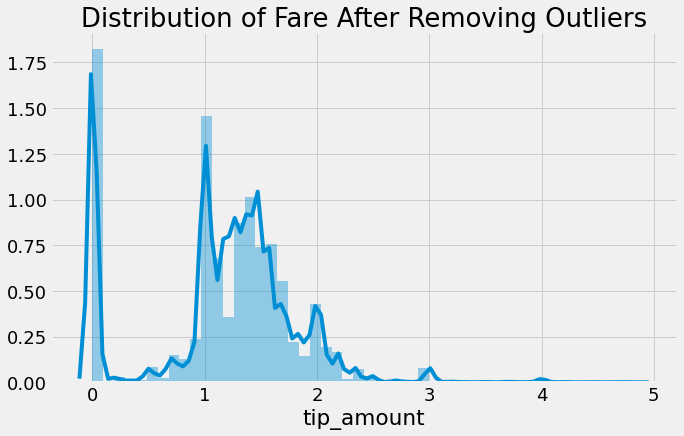

In [15]:
plt.figure(figsize = (10, 6))
sns.distplot(dataNoOutlier['tip_amount']);
plt.title('Distribution of Fare After Removing Outliers');

Text(0.5, 1.0, 'Tip Bin Graph')

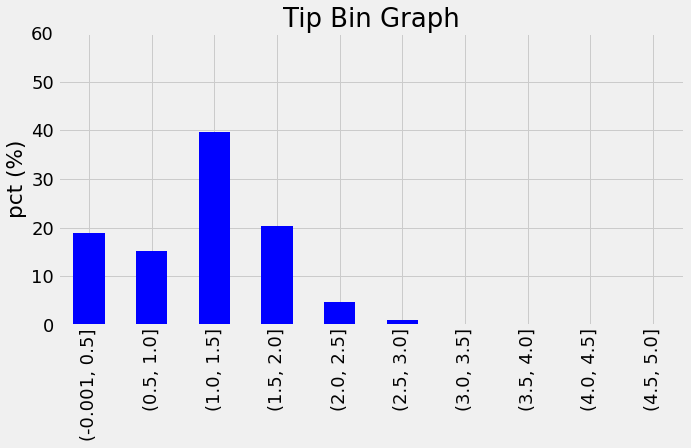

In [16]:
# Create Bar Graph for Tip Amount
bins = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
dataNoOutlier['tip-bin'] = pd.cut(dataNoOutlier['tip_amount'], bins, include_lowest = True)

# Bar plot of value counts
dataNoOutlier['tip-bin'].value_counts(sort=False, normalize=True).mul(100).plot.bar(figsize=(10, 5), color = 'b', yticks = range(0,70,10));
plt.ylabel("pct (%)")
plt.title('Tip Bin Graph')

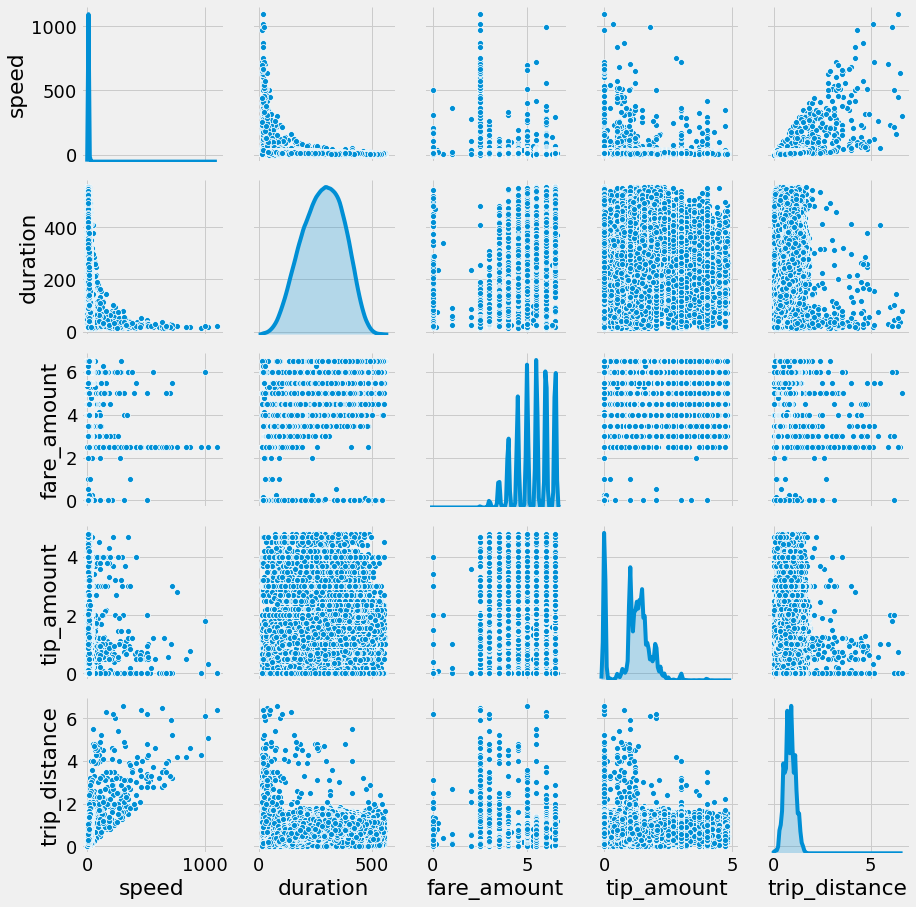

In [17]:
sns.pairplot(dataNoOutlier[["speed", "duration", "fare_amount", "tip_amount", "trip_distance"]], diag_kind = "kde")

In [18]:
stats_interested = dataNoOutlier[['trip_distance', 'fare_amount', 'tip_amount', 'rush_hour', 'over_night', 'other', 'duration', 'speed']]
stats_interested.head()

,trip_distance,fare_amount,tip_amount,rush_hour,over_night,other,duration,speed
32,0.590,5.000,0.000,1.000,0.000,0.000,265.000,8.015
33,0.800,5.000,1.260,1.000,0.000,0.000,262.000,10.992
64,0.520,4.500,1.450,1.000,0.000,0.000,221.000,8.471
74,0.540,4.000,1.060,1.000,0.000,0.000,143.000,13.594
75,0.980,5.000,1.580,1.000,0.000,0.000,260.000,13.569


In [19]:
train = stats_interested.sample(frac=0.8,random_state=0)
test = stats_interested.drop(train.index)

In [20]:
test.describe()

,trip_distance,fare_amount,tip_amount,rush_hour,over_night,other,duration,speed
count,296853.000,296853.000,296853.000,296853.000,296853.000,296853.000,296853.000,296853.000
mean,0.842,5.326,1.156,0.378,0.200,0.422,284.022,11.222
std,0.276,0.891,0.666,0.485,0.400,0.494,90.341,5.188
min,0.010,0.000,0.000,0.000,0.000,0.000,16.000,0.068
25%,0.640,4.500,1.000,0.000,0.000,0.000,218.000,8.856
50%,0.830,5.500,1.260,0.000,0.000,0.000,287.000,10.771
75%,1.030,6.000,1.550,1.000,0.000,1.000,352.000,13.012
max,6.400,6.500,4.840,1.000,1.000,1.000,554.000,685.714


In [21]:
train_labels = train.pop('tip_amount')
test_labels = test.pop('tip_amount')

In [22]:
train_stats = stats_interested.describe()
train_stats.pop('tip_amount')
train_stats = train_stats.transpose() # For better visualization purpose
train_stats

,count,mean,std,min,25%,50%,75%,max
trip_distance,1484264.000,0.842,0.276,0.010,0.640,0.830,1.030,6.600
fare_amount,1484264.000,5.325,0.892,0.000,4.500,5.500,6.000,6.580
rush_hour,1484264.000,0.376,0.484,0.000,0.000,0.000,1.000,1.000
over_night,1484264.000,0.200,0.400,0.000,0.000,0.000,0.000,1.000
other,1484264.000,0.424,0.494,0.000,0.000,0.000,1.000,1.000
duration,1484264.000,283.993,90.390,16.000,218.000,287.000,352.000,555.000
speed,1484264.000,11.224,5.413,0.067,8.848,10.760,13.014,1097.143


In [23]:
#Normalization base on Z-score
def norm(x):
        return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train)
normed_test_data = norm(test)

In [24]:
from tensorflow.python.keras.models import load_model
from tensorflow.keras.optimizers import Adam
def build_model(rate, shape):
  model = Sequential([
    layers.Dense(16, activation='relu', input_shape=[shape]),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = Adam(lr=rate)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [25]:
model = build_model(0.0000001, len(train.keys()))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Make sure nothing blows up

example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.14575996],
       [-0.04894479],
       [-0.23023427],
       [-0.10405812],
       [ 0.001156  ],
       [-0.19137108],
       [-0.2785997 ],
       [-0.0786754 ],
       [-0.70102286],
       [-0.12492628]], dtype=float32)

In [28]:
EPOCHS = 100
#Seems like loss is decreasing and accuracy is also decreasing, the model is overfitting
#Increase learning rate to see more result
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=2)#verbose=0,
  #callbacks=[tfdocs.modeling.EpochDots()])

Train on 949928 samples, validate on 237483 samples
Epoch 1/100
949928/949928 - 33s - loss: 2.0720 - mae: 1.2704 - mse: 2.0721 - val_loss: 1.9874 - val_mae: 1.2420 - val_mse: 1.9874
Epoch 2/100
949928/949928 - 31s - loss: 1.8909 - mae: 1.2068 - mse: 1.8909 - val_loss: 1.8089 - val_mae: 1.1786 - val_mse: 1.8089
Epoch 3/100
949928/949928 - 32s - loss: 1.7193 - mae: 1.1452 - mse: 1.7193 - val_loss: 1.6454 - val_mae: 1.1193 - val_mse: 1.6454
Epoch 4/100
949928/949928 - 30s - loss: 1.5667 - mae: 1.0895 - mse: 1.5667 - val_loss: 1.5032 - val_mae: 1.0669 - val_mse: 1.5032
Epoch 5/100
949928/949928 - 29s - loss: 1.4336 - mae: 1.0401 - mse: 1.4336 - val_loss: 1.3779 - val_mae: 1.0198 - val_mse: 1.3779
Epoch 6/100
949928/949928 - 29s - loss: 1.3148 - mae: 0.9948 - mse: 1.3148 - val_loss: 1.2665 - val_mae: 0.9767 - val_mse: 1.2665
Epoch 7/100
949928/949928 - 29s - loss: 1.2119 - mae: 0.9546 - mse: 1.2119 - val_loss: 1.1697 - val_mae: 0.9382 - val_mse: 1.1697
Epoch 8/100
949928/949928 - 30s - loss

Epoch 64/100
949928/949928 - 31s - loss: 0.4460 - mae: 0.4946 - mse: 0.4460 - val_loss: 0.4460 - val_mae: 0.4940 - val_mse: 0.4460
Epoch 65/100
949928/949928 - 31s - loss: 0.4455 - mae: 0.4942 - mse: 0.4455 - val_loss: 0.4454 - val_mae: 0.4935 - val_mse: 0.4454
Epoch 66/100
949928/949928 - 30s - loss: 0.4449 - mae: 0.4938 - mse: 0.4449 - val_loss: 0.4448 - val_mae: 0.4931 - val_mse: 0.4448
Epoch 67/100
949928/949928 - 29s - loss: 0.4444 - mae: 0.4934 - mse: 0.4444 - val_loss: 0.4443 - val_mae: 0.4927 - val_mse: 0.4443
Epoch 68/100
949928/949928 - 29s - loss: 0.4439 - mae: 0.4931 - mse: 0.4439 - val_loss: 0.4437 - val_mae: 0.4923 - val_mse: 0.4437
Epoch 69/100
949928/949928 - 30s - loss: 0.4434 - mae: 0.4927 - mse: 0.4434 - val_loss: 0.4432 - val_mae: 0.4920 - val_mse: 0.4432
Epoch 70/100
949928/949928 - 29s - loss: 0.4429 - mae: 0.4923 - mse: 0.4429 - val_loss: 0.4427 - val_mae: 0.4916 - val_mse: 0.4427
Epoch 71/100
949928/949928 - 29s - loss: 0.4424 - mae: 0.4920 - mse: 0.4424 - val_l

In [29]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,0.433,0.486,0.433,0.433,0.485,0.433,95
96,0.433,0.486,0.433,0.432,0.485,0.432,96
97,0.433,0.485,0.433,0.432,0.485,0.432,97
98,0.433,0.485,0.433,0.432,0.484,0.432,98
99,0.432,0.485,0.432,0.432,0.484,0.432,99


In [30]:
model.save('taxi_tip_prediction_model.h5')

In [31]:
new_model = load_model('taxi_tip_prediction_model.h5')

In [32]:
hist.head()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,2.072,1.270,2.072,1.987,1.242,1.987,0
1,1.891,1.207,1.891,1.809,1.179,1.809,1
2,1.719,1.145,1.719,1.645,1.119,1.645,2
3,1.567,1.090,1.567,1.503,1.067,1.503,3
4,1.434,1.040,1.434,1.378,1.020,1.378,4


In [33]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [tip_amount]')

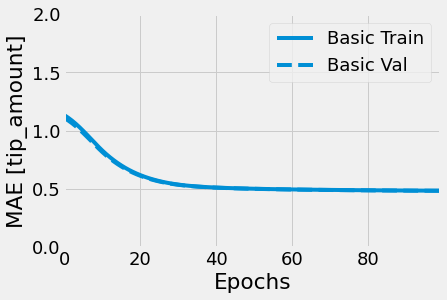

In [34]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 2])
plt.ylabel('MAE [tip_amount]')

Text(0, 0.5, 'MSE [tip^2]')

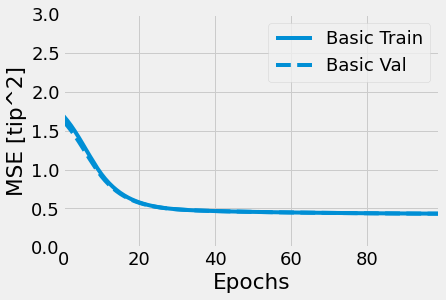

In [35]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 3])
plt.ylabel('MSE [tip^2]')

In [38]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: $ {:5.2f} ".format(mae))

296853/296853 - 5s - loss: 0.4321 - mae: 0.4847 - mse: 0.4321
Testing set Mean Abs Error: $  0.48 


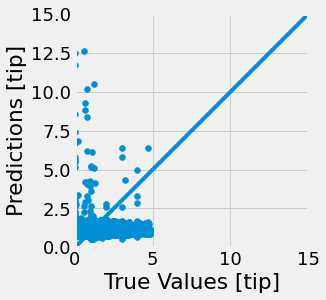

In [41]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [tip]')
plt.ylabel('Predictions [tip]')
lims = [0, 15]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


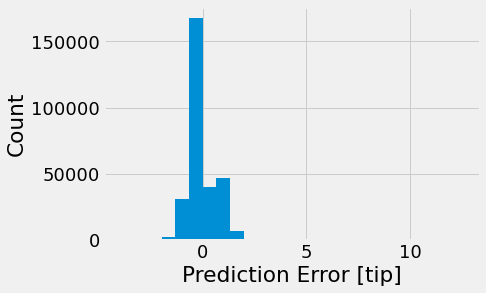

In [42]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [tip]")
_ = plt.ylabel("Count")